In [2]:
from kubernetes import client, config
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
config.load_kube_config()
graph_dir = "graphs/"

# Consensus Stats

In [4]:
stats_name = ['msg rcv total',
              'msg sent total',
              'comp time per iter',
              'xchg time per iter',
              'avg time per iter',
              'total time',
              'total iter',
              'setup time']

In [5]:
def read_metrics():
    metrics = {}

    v1 = client.CoreV1Api()
    ret = v1.list_pod_for_all_namespaces(watch=False)
    for i in ret.items:
        if i.metadata.name.startswith("my-scheduler-") or i.metadata.name.startswith("my-controller"):
            # print(f"{i.metadata.name} {i.status.pod_ip}")
            lines = v1.read_namespaced_pod_log(
                name=i.metadata.name, namespace=i.metadata.namespace)

            name = i.metadata.name
            if name.startswith('my-scheduler-'):
                metrics[name] = {}
            for line in lines.split('\n'):
                if name.startswith('my-sched') and line.startswith('{'):
                    d = json.loads(line)
                    for sn in stats_name:
                        if sn.endswith('per iter'):
                            if not sn in metrics[name]:
                                metrics[name][sn] = []
                            if sn in d:
                                metrics[name][sn].append(d[sn])
                        else:
                            if sn in d:
                                metrics[name][sn] = d[sn]
    return metrics

## stats per pod

Plot stats, large variance in computation time per iteration is perhaps due to the
short period of computation leading to incorrect timing measurement

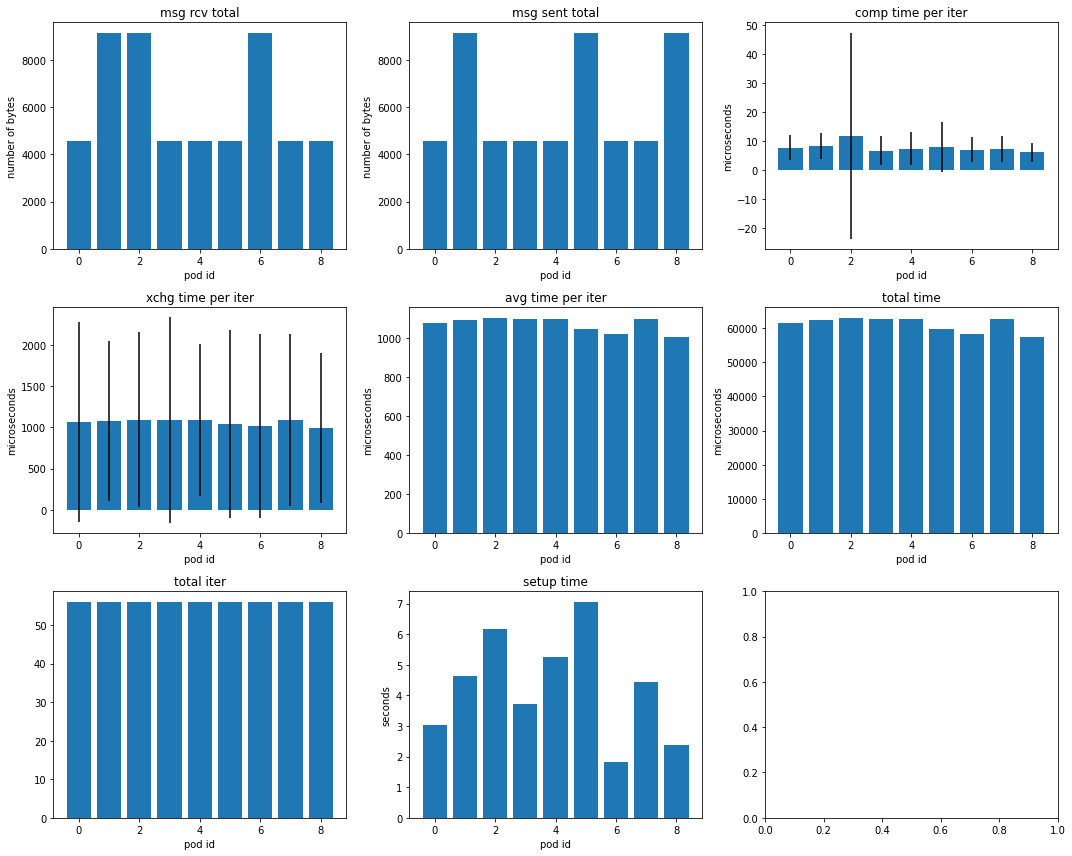

In [10]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 12)

x = range(len(metrics.keys()))


for i, sn in enumerate(stats_name):
    y = []
    a = ax[i // 3][i % 3]
    a.set_xlabel('pod id')
    if i in [0, 1]:
        a.set_ylabel('number of bytes')
    elif i in [2, 3, 4, 5]:
        a.set_ylabel("microseconds")

    if sn.find('total') != -1:
        for name in metrics:
            y.append(metrics[name][sn])
        a.bar(x, y)
        a.set_title(sn)

    elif sn.find('per iter') != -1:
        for name in metrics:
            d = np.array(metrics[name][sn])
            mean = np.mean(d)
            std = np.std(d)
            y.append([mean, std])
        y = np.array(y)
        a = ax[i // 3][i % 3]
        a.bar(x, y[:, 0], yerr = y[:, 1])
        a.set_title(sn)

    elif sn.find('setup time') != -1:
        for name in metrics:
            y.append(metrics[name]['fields.time'])
        a = ax[i // 3][i % 3]
        a.bar(x, y)
        a.set_title(sn)
        a.set_ylabel('seconds')


fig.tight_layout()
fig.savefig(f'{graph_dir}metrics-{p}pods.png')



## Stats against number of pods

In [45]:
metrics = {}
pods = range(100, 1000, 100)
runs = range(11)
for p in pods:
  with open(f'data/data-{p}pods.json', 'r') as f:
    for line in f:
      metrics[p] = json.loads(line)
print(metrics[100]['0']['my-scheduler-c5648b7d-22lrq']['setup time'])

29.934439289


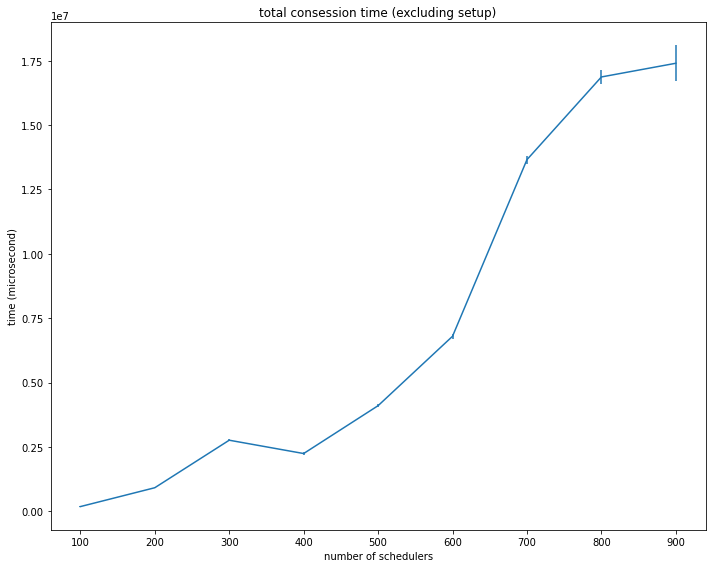

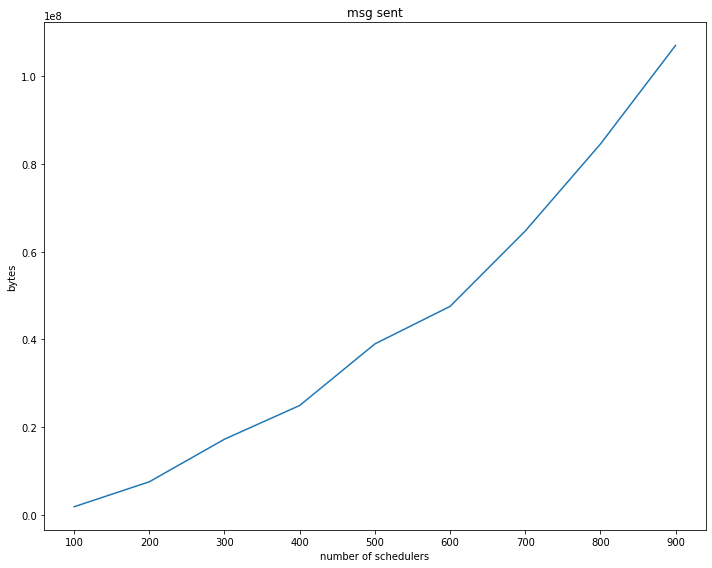

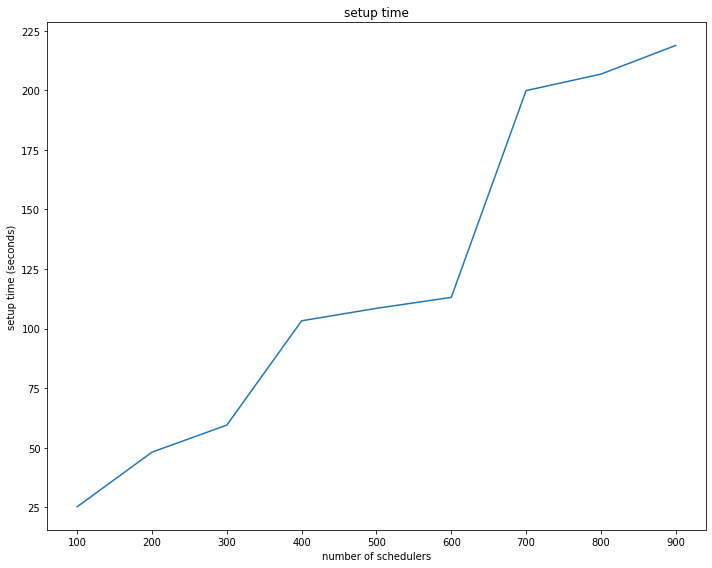

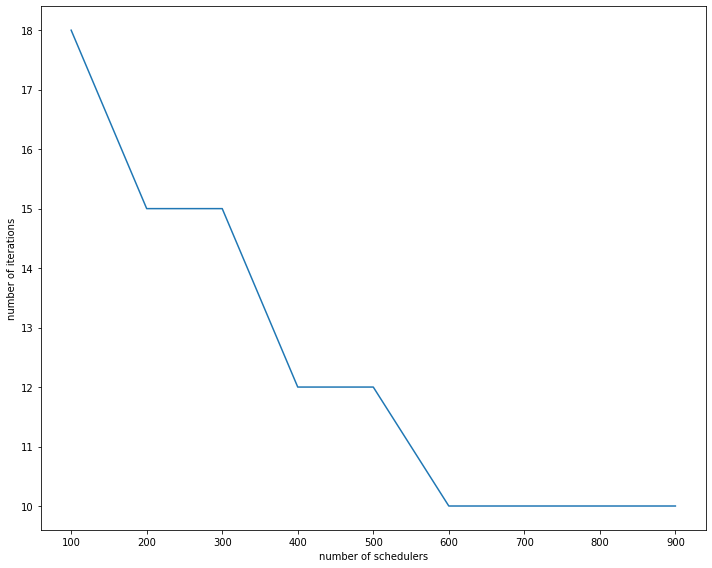

In [52]:

x = pods
y_time = []
y_msg_sent = []
y_setup = []
y_iter = []

for p in pods:
  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['total time'] for name in metrics[p][r]])
  t1.append(np.mean(t2))

  y_time.append([np.mean(t2), np.std(t2)])

  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['msg sent total'] for name in metrics[p][r]])
  t1.append(np.sum(t2))
  y_msg_sent.append([np.mean(t1), np.std(t1)])

  t2 = np.array([metrics[p]['0'][name]['setup time'] for name in metrics[p][r]])
  y_setup.append(np.mean(t2))


  t2 = np.array([metrics[p]['0'][name]['total iter'] for name in metrics[p][r]])
  y_iter.append(np.mean(t2))


  
y_time = np.array(y_time)
y_msg_sent = np.array(y_msg_sent)



fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

ax.errorbar(x, y_time[:, 0], yerr = y_time[:, 1])
ax.set_title('total consession time (excluding setup)')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('time (microsecond)')

fig.tight_layout()
fig.savefig(f'{graph_dir}latency.png')

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

ax.errorbar(x, y_msg_sent[:, 0], yerr = y_msg_sent[:, 1])
ax.set_title('msg sent')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('bytes')

fig.tight_layout()
fig.savefig(f'{graph_dir}message.png')

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.plot(x, y_setup)
ax.set_title('setup time')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('setup time (seconds)')
fig.tight_layout()
fig.savefig(f'{graph_dir}setup_time.png')


#------ iteration --------
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.plot(x, y_iter)
ax.set_xlabel('number of schedulers')
ax.set_ylabel('number of iterations')
fig.tight_layout()
fig.savefig(f'{graph_dir}iter.png')



## CPU and Memory

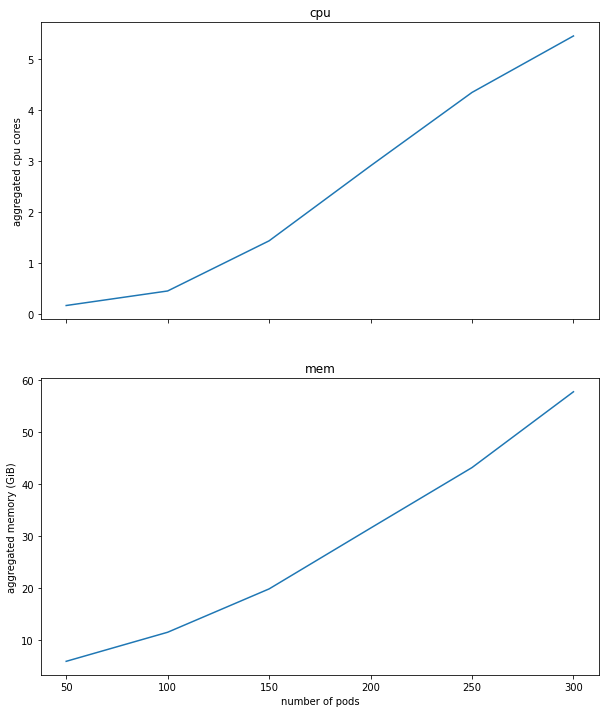

In [20]:
cpu = [0.17, 0.455, 1.438, 2.908, 4.347, 5.454]
mem = [5.97, 11.55, 19.87, 31.54, 43.16, 57.71]
pods = range(50, 350, 50)


fig, ax = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(10, 12)

ax[0].plot(pods, cpu, label='cpu')
ax[0].set_title('cpu')
ax[0].set_ylabel('aggregated cpu cores')

ax[1].plot(pods, mem, label='mem')
ax[1].set_title('mem')
ax[1].set_ylabel('aggregated memory (GiB)')
ax[1].set_xlabel('number of pods')

fig.savefig(f'{graph_dir}cpu-and-memory-usage.png')

# Placement Stats

In [43]:
pl = {}
dir = 'data/2022-08-11T17-23-29/'
with open(f'{dir}placement-300pods-60cap-1c.json', 'r') as f:
  for l in f:
    pl = json.loads(l)

In [44]:
final_w = []
for k, v in pl['0'].items():
  final_w.append(v['final w'])

final_w = np.array(final_w)
print(final_w)
print(f'sum is {np.sum(final_w)}')
print(f'mean is {np.mean(final_w)}')
print(f'std is {np.std(final_w)}')

[ 17.45333333   0.45333333  15.45333333  11.45333333   0.45333333
   4.45333333  10.45333333   7.45333333   3.45333333  25.45333333
   0.45333333   3.45333333   1.45333333  21.45333333  15.45333333
   1.45333333  17.45333333   8.45333333  15.45333333   6.45333333
  10.45333333  12.45333333   5.45333333   6.45333333   2.45333333
   6.45333333  10.45333333  15.45333333  40.45333333   1.45333333
  34.45333333   7.45333333  24.45333333   0.45333333  24.45333333
  20.45333333  19.45333333   7.45333333   1.45333333  21.45333333
  12.45333333  22.45333333   0.45333333  15.45333333  22.45333333
   7.45333333   1.45333333   4.45333333  15.45333333  28.45333333
  10.45333333   0.45333333   4.45333333   1.45333333  14.45333333
  19.45333333   7.45333333  11.45333333  -7.54666667  24.45333333
   2.45333333  26.45333333  12.45333333   0.45333333   6.45333333
  -6.54666667   2.45333333  10.45333333  14.45333333   1.45333333
  -0.54666667   9.45333333   0.45333333   5.45333333  10.45333333
   0.45333

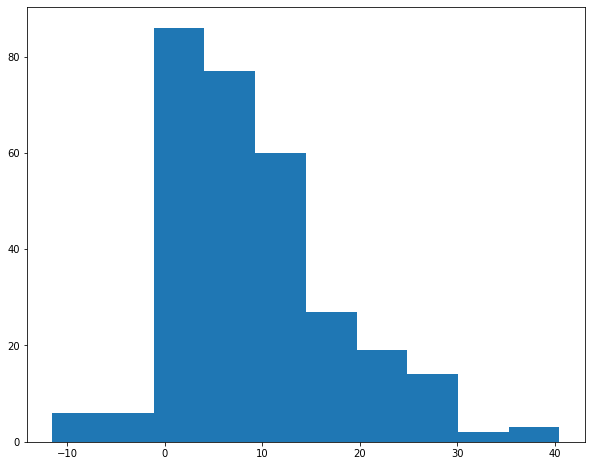

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.hist(final_w)

fig.savefig(f'{dir}finalw-100pods-1c.png')